### Table of Contents

* [Chapter 1 : Image Processing](#chapter1)
    * [Step 1 : Download data](#section_1)
        * [Section 1.1 : Import and Config](#section_1_1)
        * [Section 1.2 : Download panorama](#section_1_2)
    * [Step 2 : Pre process data - retrieve projection](#section_2)
        * [Section 2.2 : Get Heading](#section_2_2)
    * [Step 3 : Post process data - Apply projection](#section_3)
    * [Step 4 : Test](#section_4)


# Facade Parsing using Image Segmentation
Summary :   
## Chapter 1 - Image processing<a class="anchor" id="chapter1"></a>
Chapter Summary: The process is not entirely automated. Users are therefore responsible for filtering out the bette-viewed images from the extracted images.  
Author :  
Date :   

### Step 1: Download Panoramas from Google Street View<a class="anchor" id="section_1"></a>


In [ ]:
# -*- coding: utf-8 -*-
"""
Original code is from https://github.com/robolyst/streetview
Functions added in this file are
download_panorama_v1, download_panorama_v2, download_panorama_v3
Usage: 
    given latitude and longitude
    panoids = panoids( lat, lon )
    panoid = panoids[0]['panoid']
    panorama_img = download_panorama_v3(panoid, zoom=2)
"""

# https://github.com/cplusx/google-street-view-panorama-download/blob/master/streetview.py

#### 1.1 - Import and Config<a class="anchor" id="section_1_1"></a>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Package import
import cv2 
import geopandas as gps
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import shapely.geometry
import shapefile
import sys
import scaleogram
# Module import
from IPython.display import Image, display
from shapely.geometry import Polygon, Point, LineString
from skimage import io

# Local imports
from src import streetview 


#### 1.2 - Download all panorama near to the given location<a class="anchor" id="section_1_2"></a>

In [3]:
# User Inputs
lat = 57.7003612
lon = 11.9825506
# Create helper to select result images
pano_sequence = 0

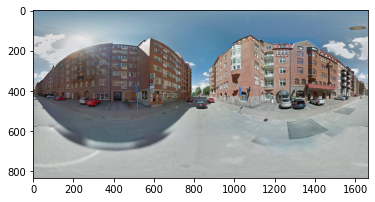

In [4]:
panoids = streetview.panoids(lat=lat, lon=lon)
panoid = panoids[pano_sequence]['panoid']
panorama = streetview.download_panorama_v3(panoid, zoom=2, disp=False)
# Save image
rgbImg = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
im_path = "data/img/Panorama_image.jpg"
cv2.imwrite(im_path, rgbImg)
height, width, vh = panorama.shape
# save the entire JSON response as a geojson for outside use
json_path = 'data/json/gsvp_data.json'
with open(json_path, 'w') as outfile:
    json.dump(panoids, outfile)
# Display panorama
plt.imshow(panorama)

### Step - 2: Read Shapefile Generated for OpenStreetMap via geopandas


In [5]:
# Load Buildings
gdf = gps.read_file("data/shp/hedasgatan.shp")
gdf = gdf.set_crs('EPSG:4326')
# Load camera positions
array_data = json.load(open('data/json/gsvp_data.json'))
df_camera = pd.json_normalize(array_data)
gdf_camera = gps.GeoDataFrame(
    df_camera, geometry=gps.points_from_xy(df_camera.lon, df_camera.lat),crs = 'EPSG:4326')

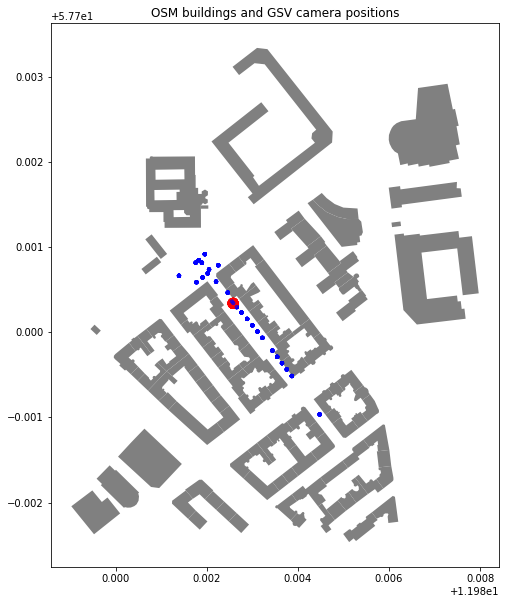

In [6]:
# Change marker visualisation for plot
c = [] # color
s = [] # size
a = [] # alpha - Transparancy
for id in list(gdf_camera['panoid']):
    if id == panoid:
        c.append('red')
        s.append(100)
        a.append(1) 
    else:
        c.append('blue')
        s.append(10)
        a.append(0.5)
# Plot

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('OSM buildings and GSV camera positions')
gdf.plot(ax = ax,color = 'grey')
for x in a:
    gdf_camera.plot(ax = ax,color = c, markersize = s,alpha = x)

### Step 2.1 - Get left and right heading <a class="anchor" id="section_2"></a>
#### Heading
The Street View location defines the placement of the camera focus for an image, but it does not define the orientation of the camera for that image. For that purpose, the StreetViewPov object defines two properties:  

- `heading` (default 0) defines the rotation angle around the camera locus in degrees relative from true north. Headings are measured clockwise (90 degrees is true east).
- `pitch` (default 0) defines the angle variance "up" or "down" from the camera's initial default pitch, which is often (but not always) flat horizontal. (For example, an image taken on a hill will likely exhibit a default pitch that is not horizontal.) Pitch angles are measured with positive values looking up (to +90 degrees straight up and orthogonal to the default pitch) and negative values looking down (to -90 degrees straight down and orthogonal to the default pitch).
![bearing_convention](media/Bearing-Convention_updated.svg)
[image source](https://uptuition.id/bearing-and-distance/)  
[GSV Documentation](https://developers.google.com/maps/documentation/javascript/streetview#StreetViewLocation)

In [11]:
# https://gist.github.com/jeromer/2005586
# LICENSE: public domain

def get_bearing(pointA, pointB):
    pointA = pointA.coords[0]
    pointB = pointB.coords[0]
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

### Step 2.2 - Get current Street segment<a class="anchor" id="section_2_2"></a>

In [12]:
current_point = Point(lon,lat)
gdf_street = gps.read_file("data/shp/roads.shp")
polygon_index = gdf_street.distance(current_point).sort_values().index[0]
street = gdf_street.loc[polygon_index]

/home/mola/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
start,end = Point(street.geometry.coords[0]), Point(street.geometry.coords[-1])

In [14]:
print(end,start)

POINT (11.9819657 57.7007214) POINT (11.9840268 57.6993365)


In [15]:
camera_direction = get_bearing(end,start)
right = (camera_direction+90) %360
left = (camera_direction+270) %360
camera_direction,left,right

(326.6839828043904, 236.68398280439033, 56.68398280439038)

In [16]:
def create_checker(point, angle, length):
    coordinates = point.coords[0]
    # unpack the first point
    x, y = coordinates
    # find the end point
    endy = y + length * math.cos(math.radians(angle))
    endx = x + length * math.sin(math.radians(angle))
    line = LineString([Point(x,y),Point(endx,endy)])
    return line

def find_building(gdf,checker):
    buildings_geometry = gdf.geometry
    for i in range(len(buildings_geometry)):
        building = buildings_geometry[i]
        if checker.intersects(building):
            building_id = gdf.iloc[i,1]
            return building_id

### Step 3 : Apply Projection on Panorama Imagery and Get single Image<a class="anchor" id="section_3"></a>

In [17]:
# Equirec2Perspec
# Equirec2Perspec is a python tool to split equirectangular panorama into normal perspective view.
# https://github.com/fuenwang/Equirec2Perspec

In [18]:
class Equirectangular:
    def __init__(self, img_name):
        self._img = cv2.imread(img_name,  cv2.IMREAD_COLOR)
        [self._height, self._width, _] = self._img.shape
        #cp = self._img.copy()  
        #w = self._width
        #self._img[:, :w/8, :] = cp[:, 7*w/8:, :]
        #self._img[:, w/8:, :] = cp[:, :7*w/8, :]
    def GetPerspective(self, FOV, THETA, PHI, height, width, RADIUS = 128):
        # THETA is left/right angle, PHI is up/down angle, both in degree
        equ_h = self._height
        equ_w = self._width
        equ_cx = (equ_w - 1) / 2.0
        equ_cy = (equ_h - 1) / 2.0

        wFOV = FOV
        hFOV = float(height) / width * wFOV

        c_x = (width - 1) / 2.0
        c_y = (height - 1) / 2.0

        wangle = (180 - wFOV) / 2.0
        w_len = 2 * RADIUS * np.sin(np.radians(wFOV / 2.0)) / np.sin(np.radians(wangle))
        w_interval = w_len / (width - 1)

        hangle = (180 - hFOV) / 2.0
        h_len = 2 * RADIUS * np.sin(np.radians(hFOV / 2.0)) / np.sin(np.radians(hangle))
        h_interval = h_len / (height - 1)
        x_map = np.zeros([height, width], float) + RADIUS
        y_map = np.tile((np.arange(0, width) - c_x) * w_interval, [height, 1])
        z_map = -np.tile((np.arange(0, height) - c_y) * h_interval, [width, 1]).T
        D = np.sqrt(x_map**2 + y_map**2 + z_map**2)
        xyz = np.zeros([height, width, 3], float)
        xyz[:, :, 0] = (RADIUS / D * x_map)[:, :]
        xyz[:, :, 1] = (RADIUS / D * y_map)[:, :]
        xyz[:, :, 2] = (RADIUS / D * z_map)[:, :]
        
        y_axis = np.array([0.0, 1.0, 0.0], float)
        z_axis = np.array([0.0, 0.0, 1.0], float)
        [R1, _] = cv2.Rodrigues(z_axis * np.radians(THETA))
        [R2, _] = cv2.Rodrigues(np.dot(R1, y_axis) * np.radians(-PHI))

        xyz = xyz.reshape([height * width, 3]).T
        xyz = np.dot(R1, xyz)
        xyz = np.dot(R2, xyz).T
        lat = np.arcsin(xyz[:, 2] / RADIUS)
        lon = np.zeros([height * width], float)
        theta = np.arctan(xyz[:, 1] / xyz[:, 0])
        idx1 = xyz[:, 0] > 0
        idx2 = xyz[:, 1] > 0

        idx3 = ((1 - idx1) * idx2).astype(bool)
        idx4 = ((1 - idx1) * (1 - idx2)).astype(bool)
        
        lon[idx1] = theta[idx1]
        lon[idx3] = theta[idx3] + np.pi
        lon[idx4] = theta[idx4] - np.pi

        lon = lon.reshape([height, width]) / np.pi * 180
        lat = -lat.reshape([height, width]) / np.pi * 180
        lon = lon / 180 * equ_cx + equ_cx
        lat = lat / 90 * equ_cy + equ_cy

        persp = cv2.remap(self._img, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)
        return persp

### Step 4 : Test<a class="anchor" id="section_4"></a>

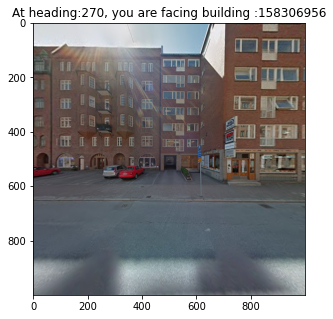

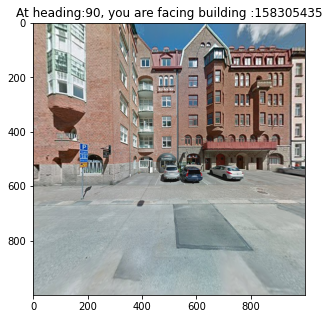

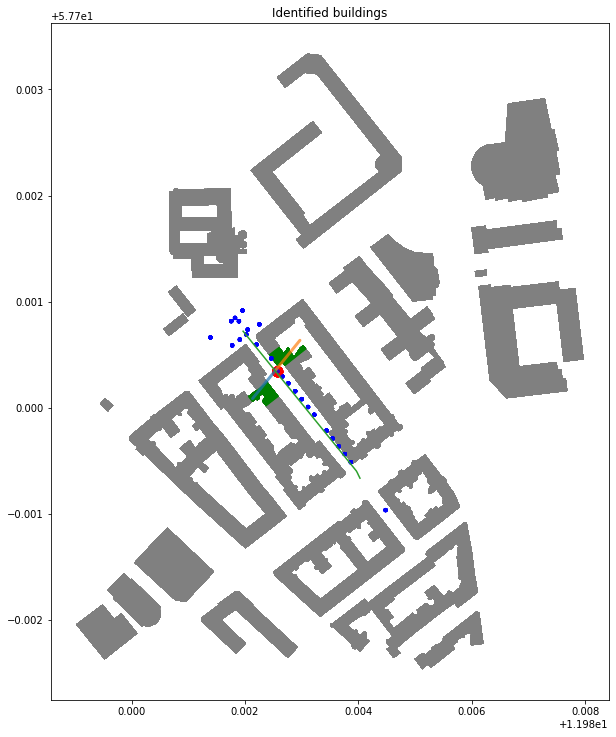

In [19]:
equ = Equirectangular(im_path)
length = 0.0005
fov= 120 # can vary but it quite good to start with
pitch= 0 # can be vary depending on buildings
height = 1000 # for large building and 720 for small buildings
width = 1000 # pretty goog to strart with
n = 0 
# Plot
building_ids = []
checkers = []
for heading in [left,right]:
    checker = create_checker(current_point,heading,length)
    checkers.append(checker)
    building_id = find_building(gdf,checker)
    building_ids.append(building_id)
i = 0
for heading in [270, 90]:
    checker = checkers[i]
    building_id = find_building(gdf,checker)
    building_ids.append(building_id)
    i+=1
    img = equ.GetPerspective(fov, heading, pitch, height, width)
    rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"data/img_eq/{n}_{heading}_{building_id}_{panoid}.jpg", img)
    n = n+1
    fig_dims = (5, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    title = f"At heading:{str(heading)}, you are facing building :{building_id}"
    ax.set_title(title)
    plt.imshow(rgbImg)
    plt.show()

# Change marker visualisation for plot
c = [] # color
s = [] # size
a = [] # alpha - Transparancy
for id in list(gdf_camera['panoid']):
    if id == panoid:
        c.append('red')
        s.append(100)
        a.append(1) 
    else:
        c.append('blue')
        s.append(10)
        a.append(0.5)
# Change building visualisation for plot    
c_build = []
a_build = []
for osm_id in list(gdf['osm_id']):
    if osm_id in building_ids:
        c_build.append('green')
        a_build.append(1)
    else:
        c_build.append('grey')
        a_build.append(0.5)
    
fig, axes = plt.subplots(figsize=(10, 20))
axes.set_title('Identified buildings')
for a_b in a_build:
    gdf.plot(ax = axes,color = c_build, alpha = a_b)
for k in a:
    gdf_camera.plot(ax = axes,color = c, markersize = s,alpha = k)
for checker in checkers:
    x, y = checker.xy
    axes.plot(x, y,alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
# Plot Street
x,y = street.geometry.xy
axes.plot(x,y)

## Error with rotating on a projected CRS

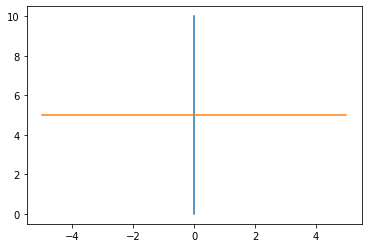

In [18]:
from shapely import affinity
from shapely.geometry import LineString

# Example geometry
line = LineString([(0,0), (0,10)])

# Rotate 30 degrees CCW from origin at the center of bbox
line_rot_center = affinity.rotate(line, 90, 'center',use_radians = False)


fig, ax = plt.subplots()
x,y = line.xy
ax.plot(x,y)
x,y = line_rot_center.xy
ax.plot(x,y)

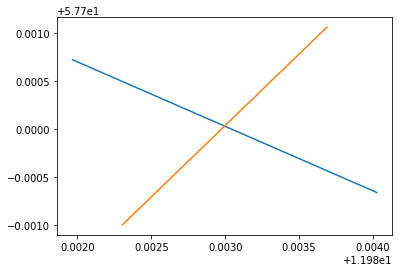

In [82]:
from shapely import affinity
from shapely.geometry import LineString

# Example geometry
line = LineString([end,start])

# Rotate 30 degrees CCW from origin at the center of bbox
line_rot_center = affinity.rotate(line, 90, 'center',use_radians = False)


fig, ax = plt.subplots()
x,y = line.xy
ax.plot(x,y)
x,y = line_rot_center.xy
ax.plot(x,y)

Unfortunately, a rotation in (lat, lon) is not performed with an affine transformation. 